In [1]:
import gurobi as gb
from gurobipy import GRB

import networkx as nx
import numpy as np
import math

# Network model

In [2]:
def init_ring(n):
    """Initializes a graph in ring structure with n nodes
    
    Args: 
        n (int): number of nodes
    
    Returns:
        G (networkx.classes.graph.Graph): Graph in ring structure
    """
    G = nx.Graph()
    for i in range(n): G.add_node(i)
    for i in range(n-1): G.add_edge(i,i+1)
    G.add_edge(0,n-1)
    pos = nx.circular_layout(G)
    nx.draw_networkx(G,pos=pos,with_labels=True)
    return(G)

def init_uniformDemand_matrix(G):
    """Returns a demand matrix, where each peer pair has the same demand in %
    
    Args:
        G (networkx.classes.graph.Graph): 
        
    Returns:
        D (numpy.ndarray): matrix with unformly distributed demands for all node pairs
    
    """
    nodesList = G.nodes
    uniformTraffic = round(1/(len(nodesList)*(len(nodesList)-1)),8)
    D = np.full((len(nodesList),len(nodesList)),uniformTraffic)
    for i in range(len(nodesList)):
        D[i][i] = 0
    return D

def calc_cost(G,D):
    """Returns the cost of traffic on a graph
    
    Args:
        G (networkx.classes.graph.Graph): network graph
        D (numpy.ndarray): Demand Graph
    Returns:
        cost (numpy.ndarray): cost of total traffic between nodes of G
    """
    nodesList = list(G.nodes)
    allShortestPath = nx.shortest_path(G)
    allShortestPathCost = [(len(allShortestPath[i][j])-1)*D[i][j]
                             for i in nodesList for j in nodesList if i!=j]
    return sum(allShortestPathCost)

def SP_edgeList(G,s,t):
    """
    Returns: Shortest Path as list of edge pairs
    """
    allShortestPath = nx.shortest_path(G)
    pathEdgeList = []
    for i in range(len(allShortestPath[s][t])-1):
        pathEdgeList.append((i,allShortestPath[s][t][i+1]))
    return pathEdgeList

def complete_node_pair_list(G):
    """
    Returns: list of all possible node pairings without duplication
    """
    nodePairList =[]
    nodes = G.nodes
    for i in G.nodes:
        nodePairList.append([])
        nodePairList[i].append((i,i))
        for j in range(i+1,len(nodes)):
            nodePairList[i].append((i,j))
    return nodePairList

# Gurobi Optimization
Implementation of the LP, which Arash proposed on 6. June 2022

In [4]:
opt_mod = gb.Model(name="linear programm")

Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-02


## Setup Network Parameters

8
[0, 1, 2, 3, 4, 5, 6, 7]
[[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)], [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7)], [(2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7)], [(3, 3), (3, 4), (3, 5), (3, 6), (3, 7)], [(4, 4), (4, 5), (4, 6), (4, 7)], [(5, 5), (5, 6), (5, 7)], [(6, 6), (6, 7)], [(7, 7)]]


/tmp/ipykernel_86302/3688721119.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


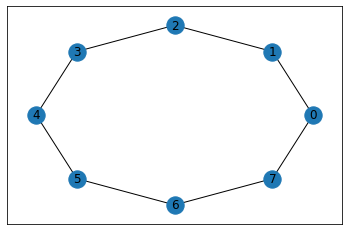

In [5]:
k = 3
G = init_ring(2**k)
D = init_uniformDemand_matrix(G)
#calc_cost(G,D)
# Setup binary adjacency matrix, i.e. unweighted
adjM = np.full((2**k,2**k),0)
A = nx.adjacency_matrix(G)
print(len(G.nodes))
allShortestPath = nx.shortest_path(G)
print(list(G.nodes))
nodesPairList = gb.tuplelist(complete_node_pair_list(G))
print(nodesPairList)

## Setting variables

In [46]:
n = len(G.nodes)
edges = gb.tuplelist(G.edges)
nodesPairList = gb.tuplelist(complete_node_pair_list(G))

maxAllowedEperNode = math.log(2**k,2) + 2
allShortestPath = nx.shortest_path(G)

# Edges/Links gb.var definition and constraints
e = []



distance = []
x = []
for i in G.nodes:
    e.append([])
    distance.append([])
    x.append([])
    for j in G.nodes:
        e[i].append(opt_mod.addVar(name=f"e_{i,j}", vtype=GRB.BINARY))
        distance[i].append(opt_mod.addVar(name=f"dist_{i,j}", vtype=GRB.INTEGER, lb=0, ub=GRB.INFINITY))
        x[i].append([])
        for u in G.nodes:
            x[i][j].append([])
            for v in G.nodes:
                x[i][j][u].append(opt_mod.addVar(name=f"x_{i,j}_{u,v}", vtype=GRB.BINARY))
                #opt_mod.addConstr(x[i][j][u][v] <= e[u][v], name="c-dist<e")
    opt_mod.addConstr(e[i][((i+1) % len(G.nodes))] == 1, name="c-ring")
    opt_mod.addConstr(distance[i][j] >= e[i][j], name="c-dist")
    opt_mod.addConstr(x[i][j][u][v] == (1 if (u,v) in SP_edgeList(G,i,j) else 0), name="c-distEdgeP")
    opt_mod.addConstr(distance[i][j]== sum(a for b in x[i][j] for a in b))

opt_mod.addConstr(sum(e[i][j] for (i,j) in nodesPairList[i])
                          <= maxAllowedEperNode, name="c-logE")
opt_mod.update()

#distance, x


In [6]:
n = len(G.nodes)
edges = gb.tuplelist(G.edges)
nodesPairList = gb.tuplelist(complete_node_pair_list(G))

maxAllowedEperNode = math.log(2**k,2) + 2
allShortestPath = nx.shortest_path(G)

# Edges/Links gb.var definition and constraints
e = []
for i in G.nodes:
    e.append([])
    for j in G.nodes:
        e[i].append(opt_mod.addVar(name=f"e_{i,j}", vtype=GRB.BINARY))
    opt_mod.addConstr(e[i][(i+1) % len(G.nodes)] == 1, name="c-ring")
        
opt_mod.addConstr(e[i][j] == e[j][i], name="c-ring")  
opt_mod.addConstr(sum(e[i][j] for (i,j) in nodesPairList[i])
                          <= maxAllowedEperNode, name="c-logE")
opt_mod.update() 

#distance, x
distance = []
x = []
for i in G.nodes:
    distance.append([])
    x.append([])
    for j in G.nodes:
        distance[i].append(opt_mod.addVar(name=f"dist_{i,j}", vtype=GRB.INTEGER, lb=0, ub=GRB.INFINITY))
        x[i].append([])
        for u in G.nodes:
            x[i][j].append([])
            for v in G.nodes:
                x[i][j][u].append(opt_mod.addVar(name=f"x_{i,j}_{u,v}", vtype=GRB.BINARY))
    #opt_mod.addConstr(x[i][j][u][v] <= e[u][v], name="c-dist<e")
    opt_mod.addConstr(distance[i][j] >= e[i][j], name="c-dist")
    opt_mod.addConstr(distance[i][j]== sum(a for b in x[i][j] for a in b))
    opt_mod.addConstr(x[i][j][u][v] == (1 if (u,v) in SP_edgeList(G,i,j) else 0), name="c-distEdgeP")
opt_mod.update() 

In [7]:
#print(len(x[0,1,x,y]))
for a in nodesPairList:
    opt_mod.setObjective(sum([distance[i][j]*D[i][j] for (i,j) in a]), GRB.MINIMIZE)
opt_mod.update()
#opt_mod.display()
opt_mod.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 34 rows, 4224 columns and 553 nonzeros
Model fingerprint: 0xde938328
Variable types: 0 continuous, 4224 integer (4160 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


In [8]:
print(e)

[[<gurobi.Var e_(0, 0) (value 1.0)>, <gurobi.Var e_(0, 1) (value 1.0)>, <gurobi.Var e_(0, 2) (value 1.0)>, <gurobi.Var e_(0, 3) (value 1.0)>, <gurobi.Var e_(0, 4) (value 1.0)>, <gurobi.Var e_(0, 5) (value 1.0)>, <gurobi.Var e_(0, 6) (value 1.0)>, <gurobi.Var e_(0, 7) (value 0.0)>], [<gurobi.Var e_(1, 0) (value 1.0)>, <gurobi.Var e_(1, 1) (value 1.0)>, <gurobi.Var e_(1, 2) (value 1.0)>, <gurobi.Var e_(1, 3) (value 1.0)>, <gurobi.Var e_(1, 4) (value 1.0)>, <gurobi.Var e_(1, 5) (value 1.0)>, <gurobi.Var e_(1, 6) (value 1.0)>, <gurobi.Var e_(1, 7) (value 0.0)>], [<gurobi.Var e_(2, 0) (value 1.0)>, <gurobi.Var e_(2, 1) (value 1.0)>, <gurobi.Var e_(2, 2) (value 1.0)>, <gurobi.Var e_(2, 3) (value 1.0)>, <gurobi.Var e_(2, 4) (value 1.0)>, <gurobi.Var e_(2, 5) (value 1.0)>, <gurobi.Var e_(2, 6) (value 1.0)>, <gurobi.Var e_(2, 7) (value 0.0)>], [<gurobi.Var e_(3, 0) (value 1.0)>, <gurobi.Var e_(3, 1) (value 1.0)>, <gurobi.Var e_(3, 2) (value 1.0)>, <gurobi.Var e_(3, 3) (value 1.0)>, <gurobi.Var 

In [9]:
if opt_mod.status == GRB.Status.OPTIMAL:
    print('Obj Function:', opt_mod.objVal)
    for v in opt_mod.getVars():
        print(v.varName, v.x)
# Another way to print the variable
    print("Optimal Solution:")
    #print(x.varName, x.x)
    #print(y.varName, y.x)        
else:
    print(opt_mod.status)

Obj Function: 0.0
e_(0, 0) 1.0
e_(0, 1) 1.0
e_(0, 2) 1.0
e_(0, 3) 1.0
e_(0, 4) 1.0
e_(0, 5) 1.0
e_(0, 6) 1.0
e_(0, 7) 0.0
e_(1, 0) 1.0
e_(1, 1) 1.0
e_(1, 2) 1.0
e_(1, 3) 1.0
e_(1, 4) 1.0
e_(1, 5) 1.0
e_(1, 6) 1.0
e_(1, 7) 0.0
e_(2, 0) 1.0
e_(2, 1) 1.0
e_(2, 2) 1.0
e_(2, 3) 1.0
e_(2, 4) 1.0
e_(2, 5) 1.0
e_(2, 6) 1.0
e_(2, 7) 0.0
e_(3, 0) 1.0
e_(3, 1) 1.0
e_(3, 2) 1.0
e_(3, 3) 1.0
e_(3, 4) 1.0
e_(3, 5) 1.0
e_(3, 6) 1.0
e_(3, 7) 0.0
e_(4, 0) 1.0
e_(4, 1) 1.0
e_(4, 2) 1.0
e_(4, 3) 1.0
e_(4, 4) 1.0
e_(4, 5) 1.0
e_(4, 6) 1.0
e_(4, 7) 0.0
e_(5, 0) 1.0
e_(5, 1) 1.0
e_(5, 2) 1.0
e_(5, 3) 1.0
e_(5, 4) 1.0
e_(5, 5) 1.0
e_(5, 6) 1.0
e_(5, 7) 0.0
e_(6, 0) 1.0
e_(6, 1) 1.0
e_(6, 2) 1.0
e_(6, 3) 1.0
e_(6, 4) 1.0
e_(6, 5) 1.0
e_(6, 6) 1.0
e_(6, 7) 1.0
e_(7, 0) 1.0
e_(7, 1) 1.0
e_(7, 2) 1.0
e_(7, 3) 1.0
e_(7, 4) 1.0
e_(7, 5) 1.0
e_(7, 6) 1.0
e_(7, 7) 0.0
dist_(0, 0) 2000000000.0
x_(0, 0)_(0, 0) 1.0
x_(0, 0)_(0, 1) 1.0
x_(0, 0)_(0, 2) 1.0
x_(0, 0)_(0, 3) 1.0
x_(0, 0)_(0, 4) 1.0
x_(0, 0)_(0, 5) 1.0
x_(0,

x_(4, 1)_(3, 7) 1.0
x_(4, 1)_(4, 0) 1.0
x_(4, 1)_(4, 1) 1.0
x_(4, 1)_(4, 2) 1.0
x_(4, 1)_(4, 3) 1.0
x_(4, 1)_(4, 4) 1.0
x_(4, 1)_(4, 5) 1.0
x_(4, 1)_(4, 6) 1.0
x_(4, 1)_(4, 7) 1.0
x_(4, 1)_(5, 0) 1.0
x_(4, 1)_(5, 1) 1.0
x_(4, 1)_(5, 2) 1.0
x_(4, 1)_(5, 3) 1.0
x_(4, 1)_(5, 4) 1.0
x_(4, 1)_(5, 5) 1.0
x_(4, 1)_(5, 6) 1.0
x_(4, 1)_(5, 7) 1.0
x_(4, 1)_(6, 0) 1.0
x_(4, 1)_(6, 1) 1.0
x_(4, 1)_(6, 2) 1.0
x_(4, 1)_(6, 3) 1.0
x_(4, 1)_(6, 4) 1.0
x_(4, 1)_(6, 5) 1.0
x_(4, 1)_(6, 6) 1.0
x_(4, 1)_(6, 7) 1.0
x_(4, 1)_(7, 0) 1.0
x_(4, 1)_(7, 1) 1.0
x_(4, 1)_(7, 2) 1.0
x_(4, 1)_(7, 3) 1.0
x_(4, 1)_(7, 4) 1.0
x_(4, 1)_(7, 5) 1.0
x_(4, 1)_(7, 6) 1.0
x_(4, 1)_(7, 7) 1.0
dist_(4, 2) 2000000000.0
x_(4, 2)_(0, 0) 1.0
x_(4, 2)_(0, 1) 1.0
x_(4, 2)_(0, 2) 1.0
x_(4, 2)_(0, 3) 1.0
x_(4, 2)_(0, 4) 1.0
x_(4, 2)_(0, 5) 1.0
x_(4, 2)_(0, 6) 1.0
x_(4, 2)_(0, 7) 1.0
x_(4, 2)_(1, 0) 1.0
x_(4, 2)_(1, 1) 1.0
x_(4, 2)_(1, 2) 1.0
x_(4, 2)_(1, 3) 1.0
x_(4, 2)_(1, 4) 1.0
x_(4, 2)_(1, 5) 1.0
x_(4, 2)_(1, 6) 1.0
x_(4, 2)_(1, 7)

# Putting it back into a graph

In [48]:
G_sol = nx.Graph()
for i in range(n): 
    G.add_node(i)

for i in G.nodes:
    for j in G.nodes:
        if e[i][j].X == 1.0:
            G.add_edge(i,j)


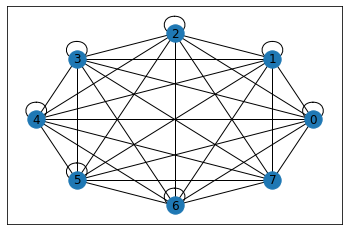

In [49]:
pos = nx.circular_layout(G)
nx.draw_networkx(G,pos=pos,with_labels=True)